In [133]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

#scikit-learn related imports
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
import scipy.stats as stats 

# pytorch relates imports
import torch
import torch.nn as nn
import torch.optim as optim 
from torch.utils.data import DataLoader, TensorDataset

# imports from captum library
from captum.attr import GradientShap, IntegratedGradients, NoiseTunnel, DeepLift

from nn_brain_age_prediction import grid_search, BrainAgeModel, train # import custom module

seed = 42 # check out differences between explicit vs. implicit call to set seed 
np.random.seed(seed)
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(seed)


In [134]:
### magic extension for printing timestamps, version numbers and hardware info
%load_ext watermark
%watermark -v -m -p numpy,pandas,matplotlib,scipy,torch,captum,scikit-learn -g 

The watermark extension is already loaded. To reload it, use:
  %reload_ext watermark
Python implementation: CPython
Python version       : 3.11.1
IPython version      : 8.24.0

numpy       : 1.26.4
pandas      : 2.2.2
matplotlib  : 3.8.4
scipy       : 1.13.0
torch       : 2.3.0
captum      : 0.7.0
scikit-learn: 1.4.2

Compiler    : GCC 11.4.0
OS          : Linux
Release     : 5.15.133.1-microsoft-standard-WSL2
Machine     : x86_64
Processor   : x86_64
CPU cores   : 8
Architecture: 64bit

Git hash: feec8d5ba6f1773d2a0da5ddd521cb04764609d9



In [135]:
# read datasets
BD = pd.read_csv('../data/BD_synthetic.csv', index_col=False)
HC = pd.read_csv('../data/HC_synthetic.csv', index_col=False)

In [136]:
# helper functions
def selectFeatures(df, feature_names):
    contains_columns = df.columns.str.contains(feature_names)
    subset_df = df.iloc[:, contains_columns]
    return subset_df

In [137]:
pattern = 'hippocampus|frontal lobe|Age' # select features that are correlated with BD vs. HC differences found in previous studies
HC_subset = selectFeatures(HC, pattern) # subset_HC

### Prepare dataset for training and testing

In [138]:
X = HC_subset.drop(columns=['Age at Visit']).values  
y = HC_subset['Age at Visit'].values 

In [139]:
normalized_X = X- np.min(X)/np.max(X) - np.min(X) # MinMax normalization

In [140]:
X_train, X_test, y_train, y_test = train_test_split(normalized_X, y, test_size=0.3, random_state=0) # create test and train sets

In [176]:
tstat, p_val = stats.ttest_ind(y_train, y_test) # ensure that the distribution of ages between the train and test sets are similar by doing a t-test
print(f"T-statistic: {tstat}, P-value: {p_val}")

T-statistic: [0.20621671], P-value: [0.83704945]


### Tensorize the datasets

In [142]:
X_train = torch.tensor(X_train).float() # convert 2D array to tensors

# convert np array to a tensor and reshape tensor to one column (1) and as many rows that might exist (-1) 
# help ensure that target tensor has consistent 2D shape
y_train = torch.tensor(y_train).view(-1, 1).float() # .view(n_samples, 1)

X_test = torch.tensor(X_test).float()
y_test = torch.tensor(y_test).view(-1, 1).float()


### Define the grid of hyperparameters

In [143]:
# Define the grid of hyperparameters
param_grid = { 
    'batch_size': [10, 20],  # Ensure batch size is smaller than the number of X_train rows
    'learning_rate': [0.001, 0.0001, 0.00001],
    'size_hidden1': [50, 75, 100],
    'size_hidden2': [25, 50, 75],
    'size_hidden3': [10, 20],
    'size_hidden4': [1],  # Output size fixed to 1
    'num_epochs': [10, 20]  
}

# Split the data into training and validation sets
train_data = TensorDataset(X_train[:60], y_train[:60])  # Training data
val_data = TensorDataset(X_train[60:], y_train[60:])  # Validation data

# Ensure that the number of features is defined
n_features = X_train.shape[1]

# Perform a t-test to ensure the distribution of ages between the train and validation sets are similar
tstat, p_val = stats.ttest_ind(y_train[:60], y_train[60:])
print(f"T-statistic: {tstat}, P-value: {p_val}")

T-statistic: [-0.44210985], P-value: [0.65981266]


In [144]:

best_params, best_score = grid_search(n_features,  param_grid, train_data, val_data)

Tested Params: {'batch_size': 10, 'learning_rate': 0.001, 'size_hidden1': 50, 'size_hidden2': 25, 'size_hidden3': 10, 'size_hidden4': 1, 'num_epochs': 10} Score: 314.11505126953125
Tested Params: {'batch_size': 10, 'learning_rate': 0.001, 'size_hidden1': 50, 'size_hidden2': 25, 'size_hidden3': 10, 'size_hidden4': 1, 'num_epochs': 20} Score: 294.335693359375
Tested Params: {'batch_size': 10, 'learning_rate': 0.001, 'size_hidden1': 50, 'size_hidden2': 25, 'size_hidden3': 20, 'size_hidden4': 1, 'num_epochs': 10} Score: 208.5943603515625
Tested Params: {'batch_size': 10, 'learning_rate': 0.001, 'size_hidden1': 50, 'size_hidden2': 25, 'size_hidden3': 20, 'size_hidden4': 1, 'num_epochs': 20} Score: 95.68388366699219
Tested Params: {'batch_size': 10, 'learning_rate': 0.001, 'size_hidden1': 50, 'size_hidden2': 50, 'size_hidden3': 10, 'size_hidden4': 1, 'num_epochs': 10} Score: 476.07220458984375
Tested Params: {'batch_size': 10, 'learning_rate': 0.001, 'size_hidden1': 50, 'size_hidden2': 50, '

### Train model on best parameters identified from grid search

In [145]:
datasets = TensorDataset(X_train, y_train) # an abstract class representing a dataset
train_iter = DataLoader(datasets, best_params['batch_size'], shuffle=True) # iterate over the dataset in batches of size 10
criterion = nn.MSELoss(reduction='sum')  # compute the loss between the predicted and true values.

print('batch_size:', best_params['batch_size'],  
      '\nnum_epoch:', best_params['num_epochs'],
     '\nlearning_rate:',best_params['learning_rate'], 
      '\nsize_hidden1:', best_params['size_hidden1'], 
      '\nsize_hidden2:',best_params['size_hidden2'], 
      '\nsize_hidden3:',best_params['size_hidden3'])

n_features = X_train.shape[1] # use X_train shape  
model = BrainAgeModel(input_size=n_features,
                      size_hidden1=best_params['size_hidden1'],
                      size_hidden2=best_params['size_hidden2'],
                      size_hidden3=best_params['size_hidden3'],
                      size_hidden4=best_params['size_hidden4'])

train(model, best_params['num_epochs'], criterion, best_params['learning_rate'], train_iter)

batch_size: 20 
num_epoch: 20 
learning_rate: 0.001 
size_hidden1: 75 
size_hidden2: 50 
size_hidden3: 20
Epoch [1]/[20] running accumulative loss across all batches: 58714404.902


### Test model on data from healthy individuals 

In [146]:
model.eval()
y_pred = model(X_test)
mse = (mean_squared_error(y_pred.detach().numpy(), y_test.detach().numpy()))
print('model err: ', round(mse, 2))

model err:  253.51


In [201]:
mae = mean_absolute_error(y_pred.detach().numpy(), y_test.detach().numpy())
print('model err: ', round(mae, 2))

model err:  13.24


### Compute attributions using various algorithms from Captum

In [148]:
ig = IntegratedGradients(model) # integral of gradients of model's outputs w/r to inp ut features, using 0 as baseline
ig_nt = NoiseTunnel(ig) # reduce noise by averaging attributions over copies of input 
dl = DeepLift(model) # alternative to gradient based method, comapre activation of neuron to a reference activation
gs = GradientShap(model) # combine SHAP and SmoothGrad, use gradients to estimate SHAP values over multiple perturbed samples

ig_attr_test = ig.attribute(X_test, n_steps=50)
ig_nt_attr_test = ig_nt.attribute(X_test)
dl_attr_test = dl.attribute(X_test)
gs_attr_test = gs.attribute(X_test, X_train) # use training set as distribution of baselines


/home/nghuixin/.pyenv/versions/3.11.1/envs/TSciM/lib/python3.11/site-packages/captum/_utils/gradient.py:57: UserWarning: Input Tensor 0 did not already require gradients, required_grads has been set automatically.
  warnings.warn(
/home/nghuixin/.pyenv/versions/3.11.1/envs/TSciM/lib/python3.11/site-packages/captum/attr/_core/deep_lift.py:304: UserWarning: Setting forward, backward hooks and attributes on non-linear
               activations. The hooks and attributes will be removed
            after the attribution is finished
  warnings.warn(


### Visualize feature importance across attribution algorithms

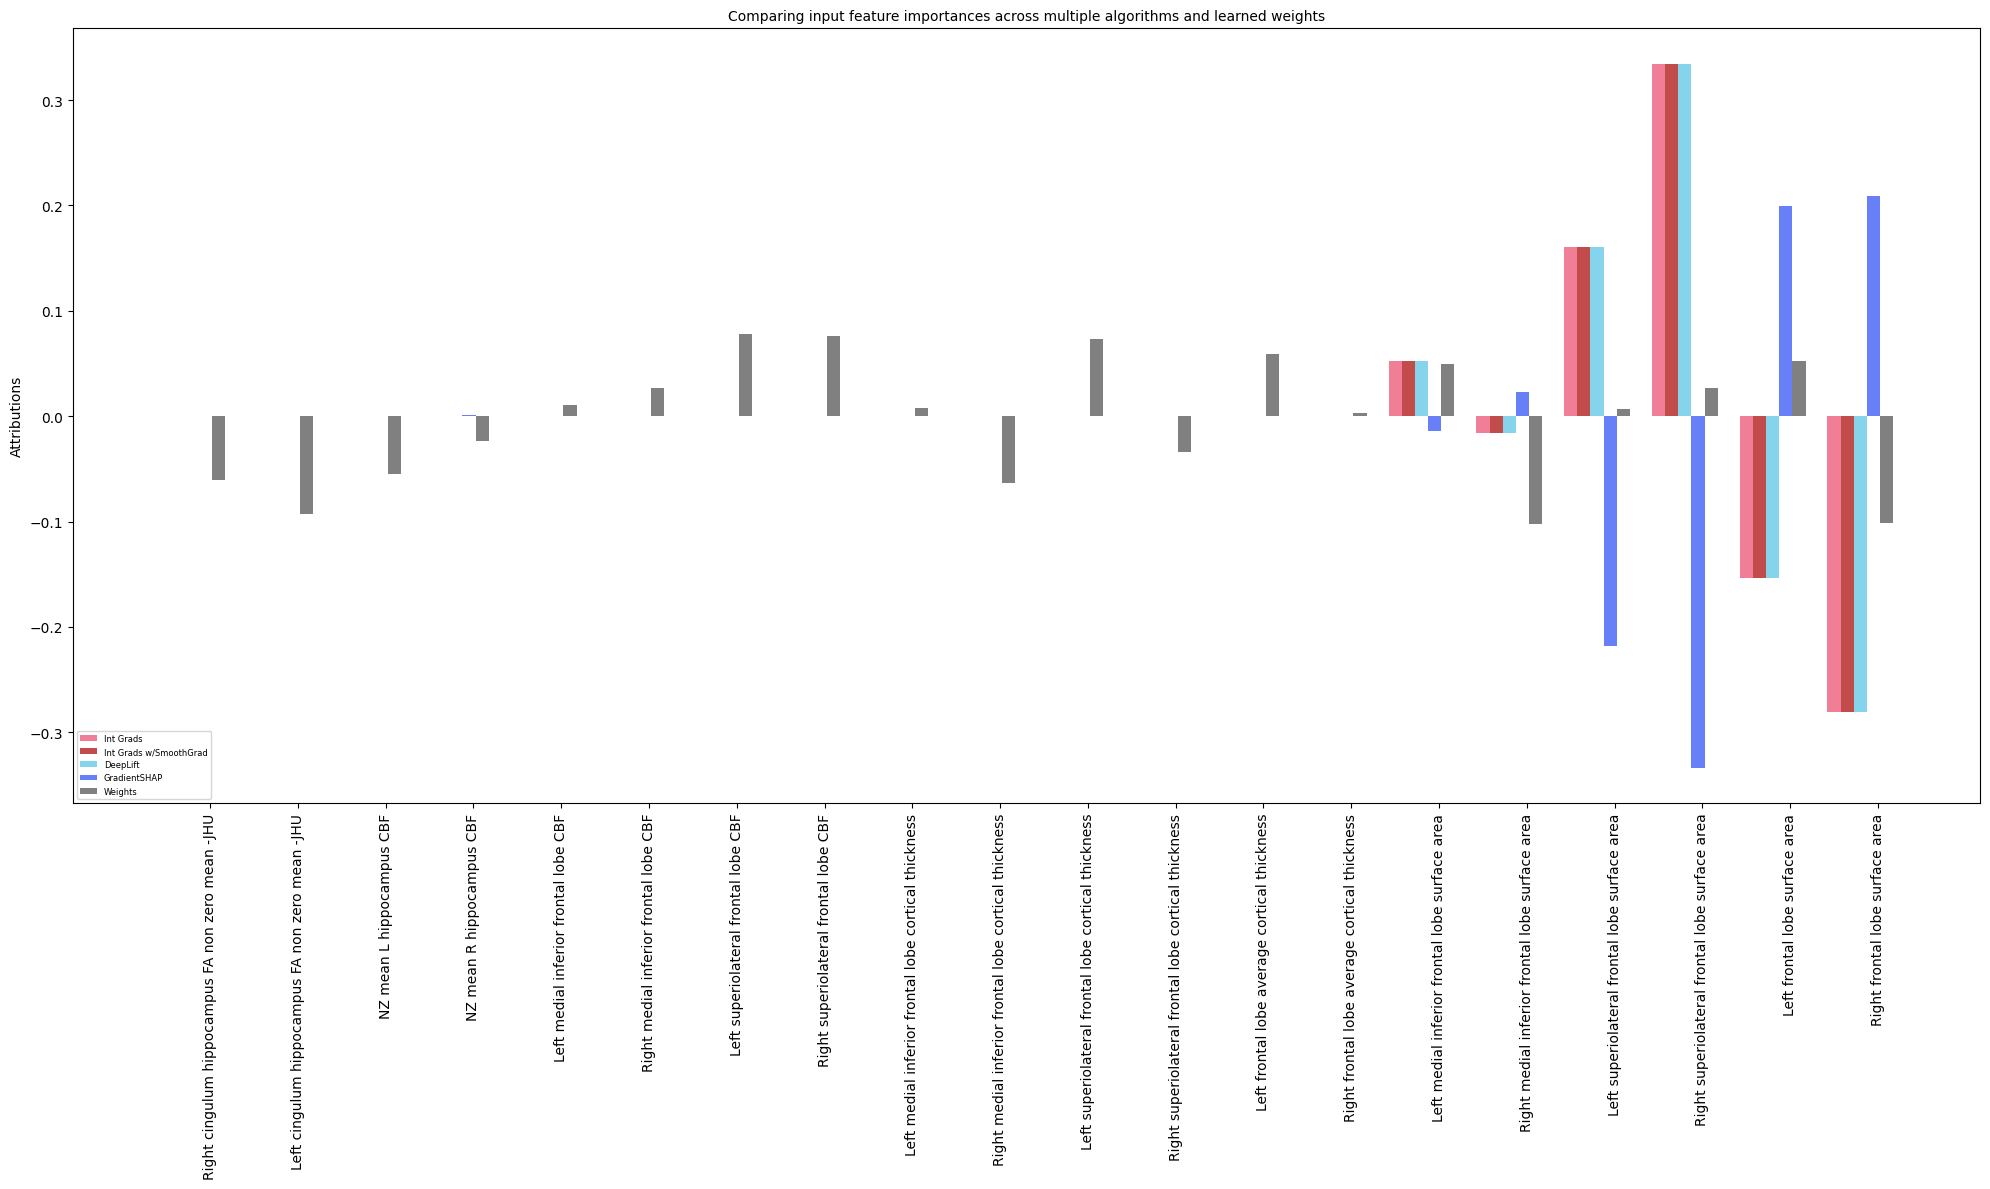

In [149]:
feature_names = HC_subset.iloc[:, 1:].columns

ig_attr_test_sum = ig_attr_test.detach().numpy().sum(0)
ig_attr_test_norm_sum = ig_attr_test_sum / np.linalg.norm(ig_attr_test_sum, ord=1)

ig_nt_attr_test_sum = ig_nt_attr_test.detach().numpy().sum(0)
ig_nt_attr_test_norm_sum = ig_nt_attr_test_sum / np.linalg.norm(ig_nt_attr_test_sum, ord=1)

dl_attr_test_sum = dl_attr_test.detach().numpy().sum(0)
dl_attr_test_norm_sum = dl_attr_test_sum / np.linalg.norm(dl_attr_test_sum, ord=1)

gs_attr_test_sum = gs_attr_test.detach().numpy().sum(0)
gs_attr_test_norm_sum = gs_attr_test_sum / np.linalg.norm(gs_attr_test_sum, ord=1)

lin_weight = model.lin1.weight[0].detach().numpy()
y_axis_lin_weight = lin_weight / np.linalg.norm(lin_weight, ord=1)

width = 0.14
legends = ['Int Grads', 'Int Grads w/SmoothGrad','DeepLift', 'GradientSHAP', 'Feature Ablation', 'Weights']


x_axis_data = np.arange(X_test.shape[1])
x_axis_data_labels = list(map(lambda idx: feature_names[idx], x_axis_data))

plt.figure(figsize=(20, 12))
ax = plt.subplot()
ax.set_title('Comparing input feature importances across multiple algorithms and learned weights')
ax.set_ylabel('Attributions')

FONT_SIZE = 10
plt.rc('font', size=FONT_SIZE)            # fontsize of the text sizes
plt.rc('axes', titlesize=FONT_SIZE)       # fontsize of the axes title
plt.rc('axes', labelsize=FONT_SIZE)       # fontsize of the x and y labels
plt.rc('legend', fontsize=FONT_SIZE - 4)  # fontsize of the legend

width = 0.15  # Assuming this variable setup exists

ax.bar(x_axis_data, ig_attr_test_norm_sum, width, align='center', alpha=0.8, color='#eb5e7c')
ax.bar(x_axis_data + width, ig_nt_attr_test_norm_sum, width, align='center', alpha=0.7, color='#A90000')
ax.bar(x_axis_data + 2 * width, dl_attr_test_norm_sum, width, align='center', alpha=0.6, color='#34b8e0')
ax.bar(x_axis_data + 3 * width, gs_attr_test_norm_sum, width, align='center',  alpha=0.8, color='#4260f5')
ax.bar(x_axis_data + 4 * width, y_axis_lin_weight, width, align='center', alpha=1.0, color='grey')
ax.autoscale_view()
plt.tight_layout()

ax.set_xticks(x_axis_data + 0.5)  # Adjust as per your code structure
ax.set_xticklabels(x_axis_data_labels, rotation=90)  # Rotation added here
legends = ['Int Grads', 'Int Grads w/SmoothGrad','DeepLift', 'GradientSHAP',  'Weights']

plt.legend(legends, loc=3)
plt.tight_layout()  # Ensures everything fits without overlap
plt.show()


### Brain-PAD of Individuals with BD

In [150]:
pattern = 'hippocampus|frontal lobe|Age' 
BD_X = selectFeatures(BD, pattern)
BD_X = BD_X.drop(columns= ['Age at Visit']).values
BD_y = BD['Age at Visit'].values

In [151]:
normalized_BD_X = BD_X - np.min(BD_X)/(np.max(BD_X)- np.min(BD_X))

In [152]:
normalized_BD_X = torch.tensor(normalized_BD_X).float()
BD_y = torch.tensor(BD_y).view(-1, 1).float()

In [174]:
model.eval()
BD_y_pred = model(normalized_BD_X)

###  Brain-PADs across BD and HC individuals

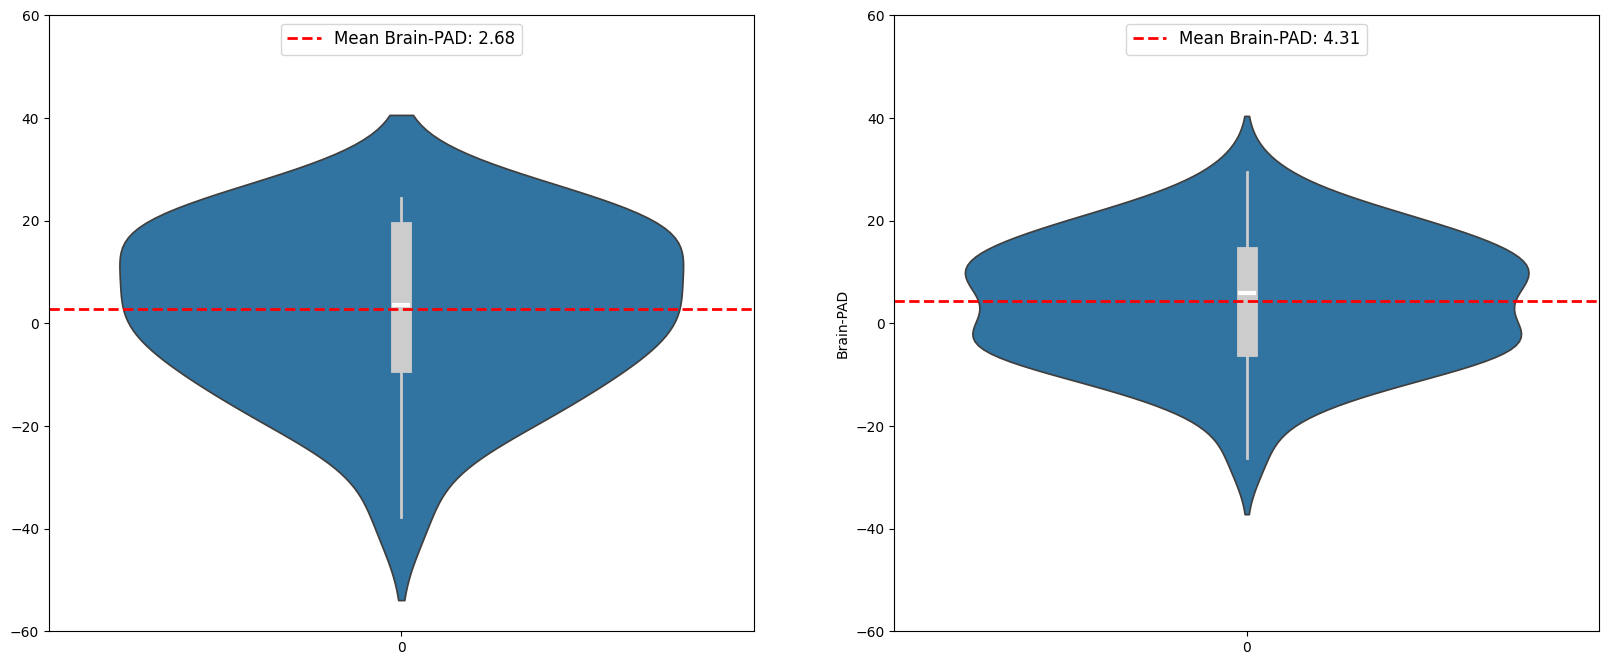

In [200]:
bpad_hc = (y_pred.detach().numpy()- y_test.detach().numpy()) # title, axis labels 
bpad_bd = (BD_y_pred.detach().numpy()- BD_y.detach().numpy())

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(20,8))
sns.violinplot(bpad_hc,  inner_kws=dict(box_width=15, whis_width=2, color=".8"), ax=ax1)
sns.violinplot(bpad_bd,  inner_kws=dict(box_width=15, whis_width=2, color=".8"), ax=ax2)


ax1.set_ylim(-60, 60)
ax2.set_ylim(-60, 60)

# Calculate means
mean_hc = np.mean(bpad_hc)
mean_bd = np.mean(bpad_bd)
line1 = ax1.axhline(mean_hc, color='r', linestyle='--', linewidth=2, label=f'Mean Brain-PAD: {mean_hc:.2f}')
line2 = ax2.axhline(mean_bd, color='r', linestyle='--', linewidth=2, label=f'Mean Brain-PAD: {mean_bd:.2f}')

ax1.legend(handles=[line1], loc = 'upper center', fontsize = 12)
ax2.legend(handles=[line2], loc = 'upper center', fontsize = 12)
plt.ylabel("Brain-PAD")
plt.show()
